## ref : https://medium.com/@thlee33/%ED%97%B7%EA%B0%88%EB%A6%AC%EB%8A%94-%EC%A2%8C%ED%91%9C%EA%B3%84-155b4ed1aae

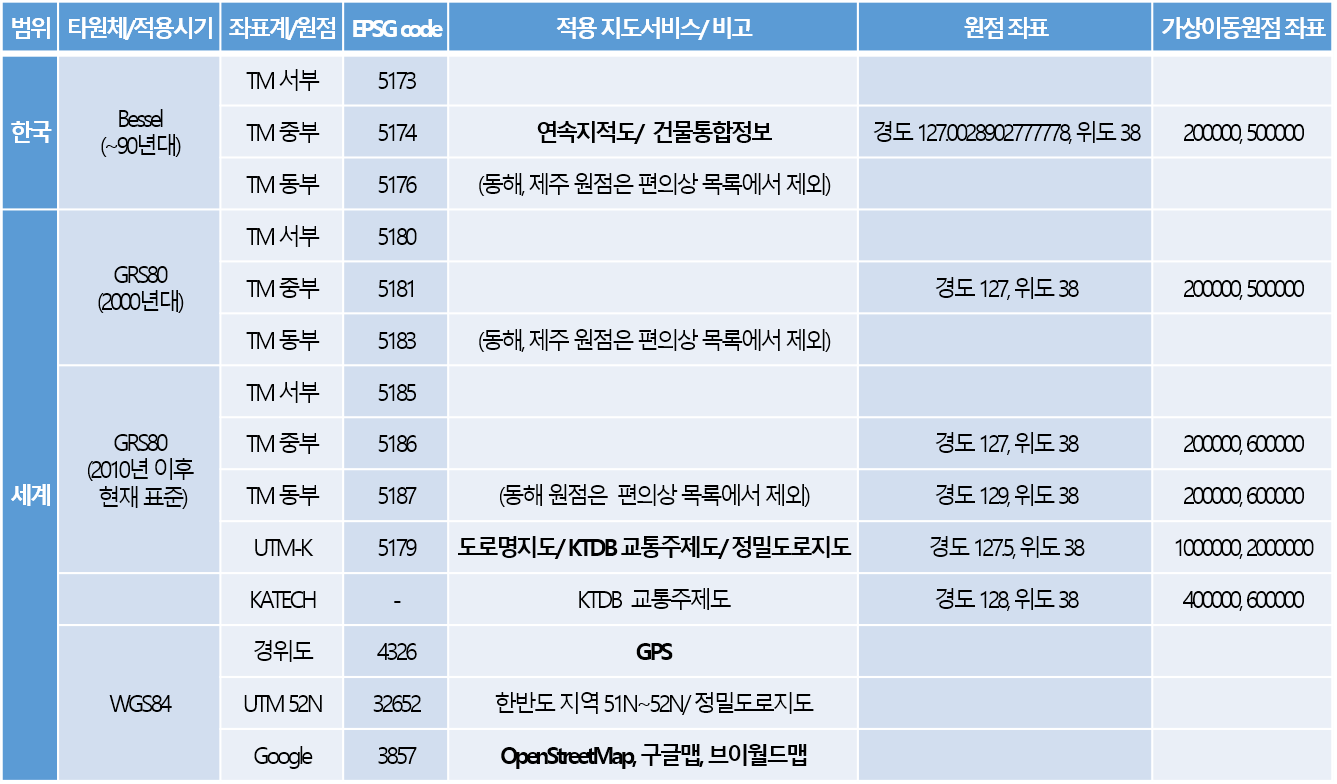

In [1]:
import pandas as pd
import numpy as np
import pyproj
from pyproj import Proj, transform
import folium

print('>>> 본 소스 작성 시 사용된 라이브러리 버전에 유의하세요!')
f'pd : {pd.__version__}  |  np : {np.__version__}  |  pyproj : {pyproj.__version__}  |  folium : {folium.__version__}'

>>> 본 소스 작성 시 사용된 라이브러리 버전에 유의하세요!


'pd : 1.0.5  |  np : 1.16.5  |  pyproj : 2.4.2.post1  |  folium : 0.11.0'

## 좌표계 변환 함수 정의(KATEC to WGS84)

In [2]:
def katec_to_wgs84(x, y):
    inProj  = Proj('+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43')
    outProj = Proj({ 'proj':'latlong', 'datum':'WGS84', 'ellps':'WGS84' })
    return transform( inProj, outProj, x, y )

In [3]:
# test code
katec_to_wgs84(291052, 551043)

(126.76472243121219, 37.55517970659813)

## 필요 데이터 로드 - 셀·행정구역 매핑 테이블

In [4]:
admdong_nm_df = pd.read_csv('data/2_ADMDONG_CD-ADMDONG_NM.csv', usecols=['admdong_cd', 'sido_nm', 'sgg_nm', 'admdong_nm'])
coord_df = pd.read_csv('data/1_50CELL-ADMDONG_CD.csv').merge(admdong_nm_df, how='left', on='admdong_cd')
# coord_df['lng'], coord_df['lat'] = coord_df[['x_axis', 'y_axis']]\
#                                     .apply(lambda df : grs80_to_wgs84(df['x_axis'], df['y_axis']), axis=1)

print(coord_df.shape)
pd.concat([coord_df.head(2), coord_df.tail(2)])

(1405052, 7)


,id,x_axis,y_axis,admdong_cd,sido_nm,sgg_nm,admdong_nm
0,30509513,227352,81043,50110310,제주특별자치도,제주시,한경면
1,30509514,227352,81093,50110310,제주특별자치도,제주시,한경면
1405050,63073159,360902,422393,30110725,대전광역시,동구,대청동
1405051,63085351,360952,422543,30110725,대전광역시,동구,대청동


## 서울시 자치구별 샘플 cell 시각화

In [5]:
sample_df = coord_df[coord_df.sido_nm == '서울특별시'].sort_index()
sample_df = pd.concat([ sample_df.drop_duplicates('sgg_nm', keep='last'),
                        sample_df.drop_duplicates('sgg_nm', keep='first') ]).sort_values('id').reset_index(drop=True)

sample_df['lat'] = katec_to_wgs84(sample_df.x_axis.to_list(), sample_df.y_axis.to_list())[1]
sample_df['lng'] = katec_to_wgs84(sample_df.x_axis.to_list(), sample_df.y_axis.to_list())[0]

print(sample_df.shape)
sample_df.head()

(50, 9)


,id,x_axis,y_axis,admdong_cd,sido_nm,sgg_nm,admdong_nm,lat,lng
0,46047699,291052,551043,11500620,서울특별시,강서구,공항동,37.555180,126.764722
1,47071443,295252,544443,11530790,서울특별시,구로구,수궁동,37.496208,126.813190
2,47278741,296102,548693,11470580,서울특별시,양천구,신월3동,37.534592,126.822200
3,47937034,298802,553043,11440740,서울특별시,마포구,상암동,37.574082,126.852145
4,48339072,300452,543093,11545510,서울특별시,금천구,가산동,37.484621,126.872170


In [6]:
seoul_coord = [37.56, 126.982]

map1 = folium.Map(location=seoul_coord, zoom_start=11, width='80%', height='80%')
for lat, lng, sgg, dong in zip(sample_df.lat, sample_df.lng, sample_df.sgg_nm, sample_df.admdong_nm):
    folium.Marker((lat, lng), tooltip=f'{sgg} {dong}').add_to(map1)

map1.save('source_output/map1_seoul.html')  # 한글 tooltip은 html 파일로 확인 가능
map1

## 서울시 송파구 행정동별 샘플 cell 시각화

In [7]:
gangnam_df = coord_df[coord_df.sgg_nm == '송파구']
gangnam_df = pd.concat([ gangnam_df.drop_duplicates('admdong_nm', keep='last'),
                         gangnam_df.drop_duplicates('admdong_nm', keep='first') ]).sort_values('admdong_nm').reset_index(drop=True)
gangnam_df['lat'] = katec_to_wgs84(gangnam_df.x_axis.to_list(), gangnam_df.y_axis.to_list())[1]
gangnam_df['lng'] = katec_to_wgs84(gangnam_df.x_axis.to_list(), gangnam_df.y_axis.to_list())[0]

print(gangnam_df.shape)
gangnam_df.head()

(54, 9)


,id,x_axis,y_axis,admdong_cd,sido_nm,sgg_nm,admdong_nm,lat,lng
0,53190315,320352,544143,11710631,서울특별시,송파구,가락1동,37.496012,127.097047
1,53653489,322252,543743,11710631,서울특별시,송파구,가락1동,37.492570,127.118575
2,53763195,322702,543993,11710632,서울특별시,송파구,가락2동,37.494861,127.123637
3,54092299,324052,544043,11710632,서울특별시,송파구,가락2동,37.495423,127.138897
4,53568177,321902,544293,11710620,서울특별시,송파구,가락본동,37.497496,127.114559


In [8]:
map2 = folium.Map(location=gangnam_df.loc[15, ['lat', 'lng']].to_list(), zoom_start=12, width='80%', height='80%')
for lat, lng, sgg, dong in zip(gangnam_df.lat, gangnam_df.lng, gangnam_df.sgg_nm, gangnam_df.admdong_nm):
    folium.Marker((lat, lng), tooltip=f'{sgg} {dong}').add_to(map2)    

map2.save('source_output/map2_songpa.html')
map2

In [9]:
# columns = coord_df.columns
# coord_df=coord_df.astype({'x':'float64','y':'float64'}, copy=True, errors='ignore')
# coord_np = coord_df.iloc[0:100,:].values

# for i in range(len(coord_np)):
#     x=datanp[i,1]
#     y=datanp[i,2]
#     xy = grs80_to_wgs84(x,y)
#     datanp[i,1:3] = xy